In [2]:
from Utils import * 
from param_tools import *
import pickle
import matplotlib

In [72]:
## Select Padrameters

n_pts = 75 
noise = 0.05 #add gaussain noise
energyType = 1 # 0:harmonic, 1:spring
S = 0 # rest length of spring
K = 1e2 # spring constant
n_steps = 500 # number of optimization steps
alpha = 1e-5 # need to be much smaller for spring energy (1e-5 is reasonable for spring energy with K = 1e2)
intermediate_plots = 0 # generate some plots as the script runs for debugging purpose

In [73]:
## Generate data

np.random.seed(10)

data = generate_noisy_sphere(n_pts, radius=1, noise=noise)



In [74]:
# Get homological information from Ripser

max_barcode = 1 #off/on/SECOND Largest choice of barcode, overides choose and max_nhood if > 0, -1: smallest code
field = 5 # for computing cocycles
cocycles, distance_matrix, ripser_result = initial_ripser_calculation(data, field, plot=0)
if max_barcode != 0:
    choose = 0
    length = 0
    lengths = []
    n_sizes = []
    for i in range(0, len(cocycles[2][:])):
        birth = ripser_result['dgms'][2][i][0]
        death = ripser_result['dgms'][2][i][1]
        life = death - birth
        lengths.append(life)
        n_sizes.append((1 * death + 3 * birth) / 4)
    if max_barcode == 1:
        idx = np.argmax(lengths)
        choose = idx
        max_nhood_size = n_sizes[idx]
    if max_barcode == 2:
        n = 2
        idxes = [lengths.index(i) for i in sorted(lengths, reverse=True)][:n]
        idx = idxes[1]
        choose = idx
        max_nhood_size = n_sizes[idx]
    if max_barcode == -1:
        idx = np.argmin(lengths)
        choose = idx
        max_nhood_size = n_sizes[idx]
else:
    birth = ripser_result['dgms'][2][choose][0]
    death = ripser_result['dgms'][2][choose][1]
    max_nhood_size = (death + 3 * birth) / 4

selected_cocycle = cocycles[2][choose]
simplices, values = dim_2_get_edges_and_cohomology_info(distance_matrix, selected_cocycle, max_nhood_size)
trg_list = np.fliplr(np.array(simplices))

Sum of Values:24
Choose:0


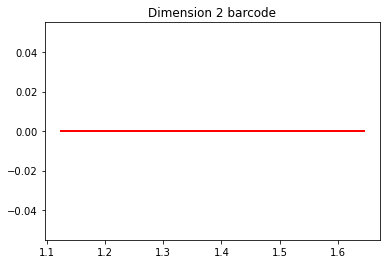

In [75]:
# Make barcode
sum_val = np.sum(values)
print('Sum of Values:'+str(sum_val))
plt.figure()
for i in range(0, len(cocycles[2][:])):
    birth = ripser_result['dgms'][2][i][0]
    death = ripser_result['dgms'][2][i][1]
    if i == choose:
        plt.hlines(y=i, xmin=birth, xmax=death, linewidth=2, color='r')
        print('Choose:'+str(i))
    else:
        plt.hlines(y=i, xmin=birth, xmax=death, linewidth=2, color='k')
plt.title('Dimension 2 barcode')
plt.show()

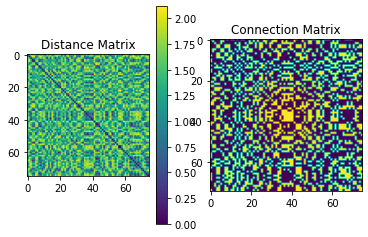

Values are:[0 1 4]  N Trgs:6804  Nonzero:15


In [76]:
## Plot initial data
initial_plot = 1
if initial_plot == 1:
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(distance_matrix)
    plt.colorbar()
    plt.title('Distance Matrix')
    plt.subplot(1,2,2)
    connection_matrix = distance_matrix.copy()
    connection_matrix[distance_matrix < max_nhood_size] = 1
    connection_matrix[distance_matrix > max_nhood_size] = 0
    plt.imshow(connection_matrix)
    plt.title('Connection Matrix')
    plt.show()
    print('Values are:' + str(np.unique(values)) + '  N Trgs:' + str(len(trg_list)) + '  Nonzero:' + str(np.count_nonzero(values)))


Setting up points and barycenters


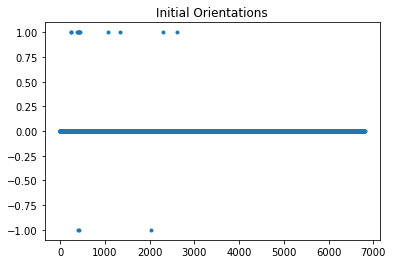

In [77]:
## Barycenters and points
print('Setting up points and barycenters')
bary = np.zeros(trg_list.shape)
orient = np.zeros(len(trg_list))
for i in range(len(trg_list)):
    if values[i] == 0:
        bary[i, :] = [1, 0, 0]
    else:
        bary[i, :] = [-1, 0, 0]
        if values[i] == 1:
            orient[i] = 1
        else:
            orient[i] = -1
pts = np.zeros([len(data), 3])
pts[:,0] = 1
plt.figure()
plt.plot(orient, '.')
plt.title('Initial Orientations')
plt.show()

In [78]:
# Minimization
NRG = []
print('Beginning Minimization')
for i in range(n_steps):
    # Compute NRG
    E, E_list, A_list, grad = compute_grad_and_NRG(pts, trg_list, bary, orient, energyType, S, K)
    NRG.append(E)
    if math.isnan(E):
        print('NAN at i='+str(i))
        break
    # update Grad
    pts, bary = compute_grad_step(pts, trg_list, grad, bary, alpha, i)

    print(i, E)
    # if i % (n_steps // 5) == 0:
    #     if dataType == 0 or dataType == 2 or dataType == 3 or dataType == 4:
    #         plot_data_and_results(data, pts, title=str(i))
    #     plt.show()
    if i > 1:
        if NRG[-2] < NRG[-1]:
            print('Increasing at '+str(i))
            #break

# converge
plt.figure()
plt.plot(np.arange(len(NRG)), NRG)
plt.title('Energy')
plt.show()

Beginning Minimization
0 1740.6709702097637
1 1739.0055222945803
2 1734.6402792765916
3 1727.2954904716971
4 1716.9626668677226
5 1703.6475449935363
6 1687.376181662995
7 1668.2062452697933
8 1646.2495893149035
9 1621.6963571758824
10 1594.836417335212
11 1566.0618499500317
12 1535.847604276246
13 1504.711012100224
14 1473.1606126228796
15 1441.665744139468


KeyboardInterrupt: 

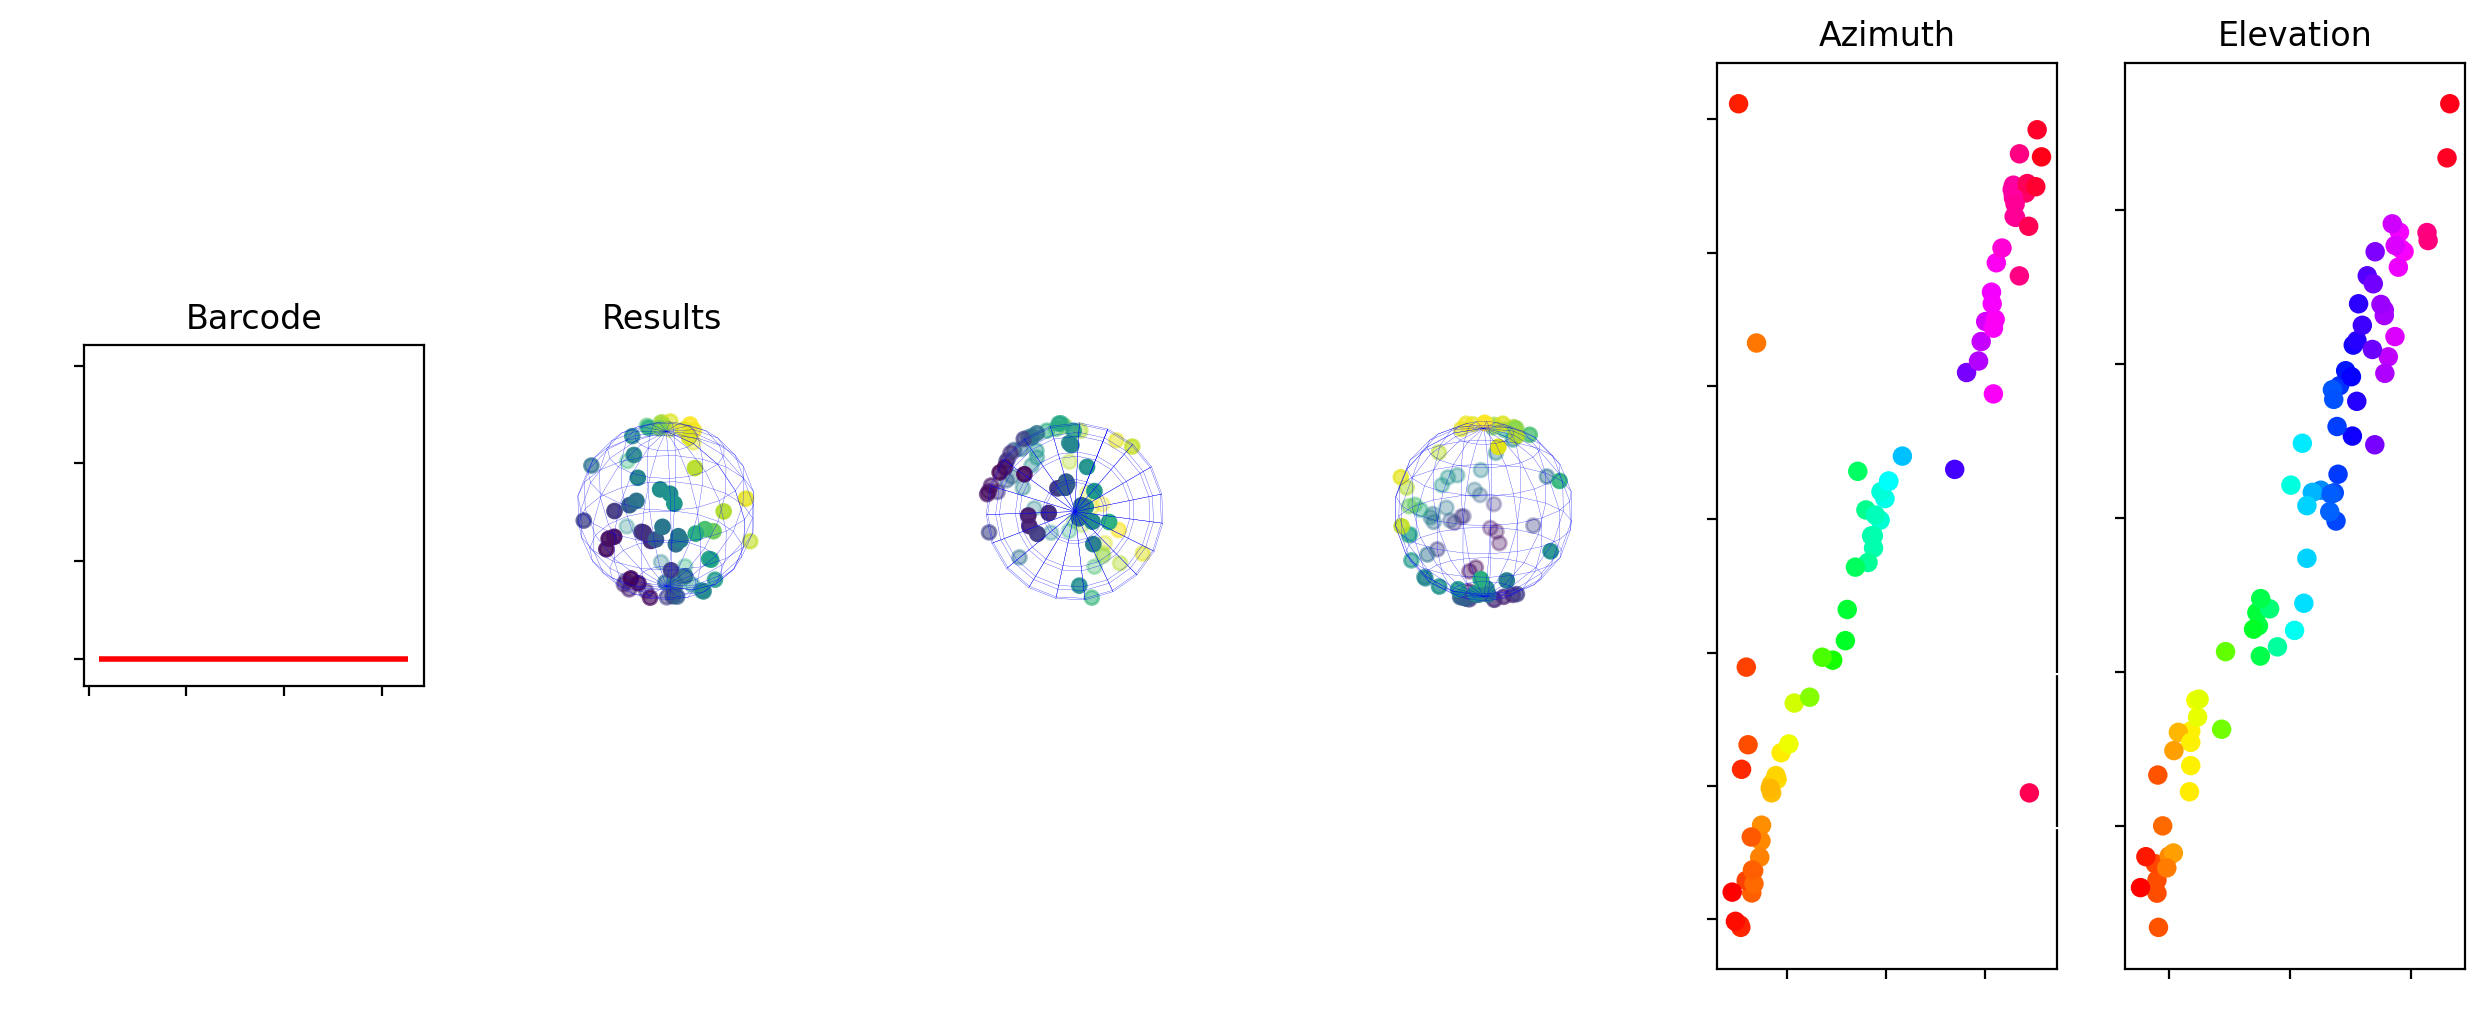

In [63]:
# Make plots
fig = plt.figure(figsize=(18, 6), dpi=200)
simplices = np.array(simplices)
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='->', shrinkA=0, shrinkB=0)

ax = fig.add_subplot(1, 7, 2)
for i in range(0, len(cocycles[2][:])):
    birth = ripser_result['dgms'][2][i][0]
    death = ripser_result['dgms'][2][i][1]
    if i == choose:
        plt.hlines(y=i, xmin=birth, xmax=death, linewidth=2, color='r')
    else:
        plt.hlines(y=i, xmin=birth, xmax=death, linewidth=2, color='k')
plt.title('Barcode')
plt.yticks(color='w')
plt.xticks(color='w')
plt.axis('Square')

u, v = np.mgrid[0:2 * np.pi:20j, 0:np.pi:10j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
c = np.sum(data, axis=1).tolist()
c = c - np.min(c)
c = c/np.max(c)
for i in range(3):
    ax = fig.add_subplot(1, 7, 3 + i, projection='3d')
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], marker='.', c=c, s=100)
    ax.plot_wireframe(x, y, z, color='b', linewidth=.1)
    ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
    if i == 1:
        ax.view_init(-90, -20)
    if i == 2:
        ax.view_init(-20, 90)
    if i == 0:
        plt.title('Results')
    ax.axis('off')
    ax.grid(visible=None)

R1, pts1_rotated = align_spheres(pts, data)
p1, s1 = coord_plot_sphere(pts1_rotated, data, plot=0)
plt.subplot(1, 7, 6)
plt.scatter(p1[:, 0], s1[:, 0], c=p1[:, 0], cmap='hsv')
plt.title('Azimuth')
plt.yticks(color='w')
plt.xticks(color='w')
plt.subplot(1, 7, 7)
plt.scatter(p1[:, 1], s1[:, 1], c=p1[:, 1], cmap='hsv')
plt.title('Elevation')
plt.yticks(color='w')
plt.xticks(color='w')
plt.show()